In [ ]:
# Import modules from main
import sys
import os
repo_root = os.path.dirname(os.path.abspath(''))
if repo_root not in sys.path:
    sys.path.append(repo_root)

In [ ]:
# %load_ext autoreload
# %autoreload 2 
#%reload_ext autoreload

In [3]:
## Importing the required libraries
from main.model import DeepAntiPhish
from main.feature_engineering import process, imbalance_ratio
from main.runners import training
from main.helpers import get_feature_count, prettyPrintMetrics, compute_metrics
from main.constants import TEST_DATA          


In [4]:
# Initiate the training and test loader
train_loader, test_loader = process(pathfix='../')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  13 | elapsed:    4.2s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done   6 out of  13 | elapsed:    4.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    5.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed: 10.0min finished


In [5]:
import warnings
warnings.filterwarnings('ignore')
%config Application.log_level = 'ERROR'

In [6]:
# Initialize model and commence training
ratio = imbalance_ratio(train_loader)
model = DeepAntiPhish(input_dims=get_feature_count(train_loader))
modelPerformance = training(model, train_loader, test_loader, 
                         pos_neg_ratio=ratio,
                         cycles=2, 
                         epochs_per_cycle=5,
                         lr=4.8e-3,
                         weight_decay=1.8e-4)


---------------- Cycle 01/02 -----------------------------
→ Epoch 01/5 –  	  New BEST in this cycle      Loss: 0.0280    | Accuracy: 99.68%    | Precision: 0.9997    | Recall: 0.9963    | F1-score: 0.9980
    
→ Epoch 02/5 – → Epoch 03/5 – → Epoch 04/5 – → Epoch 05/5 –  
★  Updated GLOBAL best →      Loss: 0.0280    | Accuracy: 99.68%    | Precision: 0.9997    | Recall: 0.9963    | F1-score: 0.9980
    

 Saved model at path: models/deep_antiphish_best_model.pth with val_loss = 0.9968)

 Saved model at path: models/deep_antiphish_cycle01.pth with val_loss = 0.9968)

---------------- Cycle 02/02 -----------------------------
→ Epoch 01/5 –  	  New BEST in this cycle      Loss: 0.0190    | Accuracy: 99.49%    | Precision: 1.0000    | Recall: 0.9937    | F1-score: 0.9968
    
→ Epoch 02/5 –  	  New BEST in this cycle      Loss: 0.0185    | Accuracy: 99.51%    | Precision: 1.0000    | Recall: 0.9939    | F1-score: 0.9969
    
→ Epoch 03/5 – → Epoch 04/5 – → Epoch 05/5 – 
 Saved model at 

In [8]:
# Evaluation of the best model
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DeepAntiPhish(input_dims=get_feature_count(train_loader)).to(device)
model.load_state_dict(torch.load("models/deep_antiphish_best_model.pth",
                                 map_location=device))
model.eval()
perf, y_true, y_pred = compute_metrics(model, test_loader, device=device)
prettyPrintMetrics(perf, "LOADED GLOBAL BEST : ",
                   print_confusion_matrix=True,
                   print_classification_report=True)


 LOADED GLOBAL BEST :      Loss: 0.0166    | Accuracy: 99.56%    | Precision: 1.0000    | Recall: 0.9945    | F1-score: 0.9972
    

 Confusion Matrix:
 [[10495     1]
 [  237 42952]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     10496
           1       1.00      0.99      1.00     43189

    accuracy                           1.00     53685
   macro avg       0.99      1.00      0.99     53685
weighted avg       1.00      1.00      1.00     53685



In [9]:
from main.reporting import *

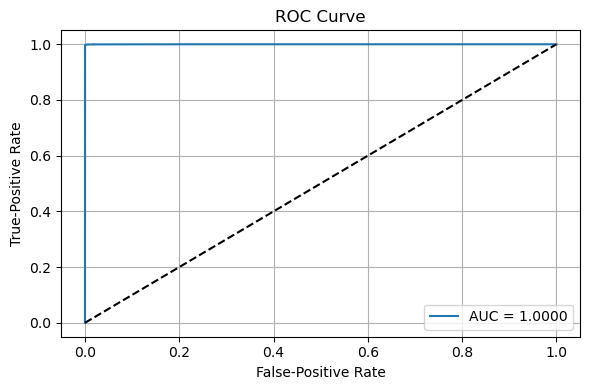

In [10]:
# ROC Curve
y_true, y_prob = plot_roc_curve(model, test_loader, device)

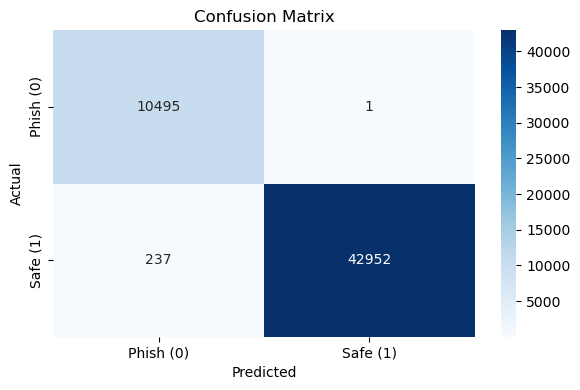

In [11]:
# Confusion Matrix
cm = plot_confusion_matrix(y_true, (y_prob>=.5).astype(int))

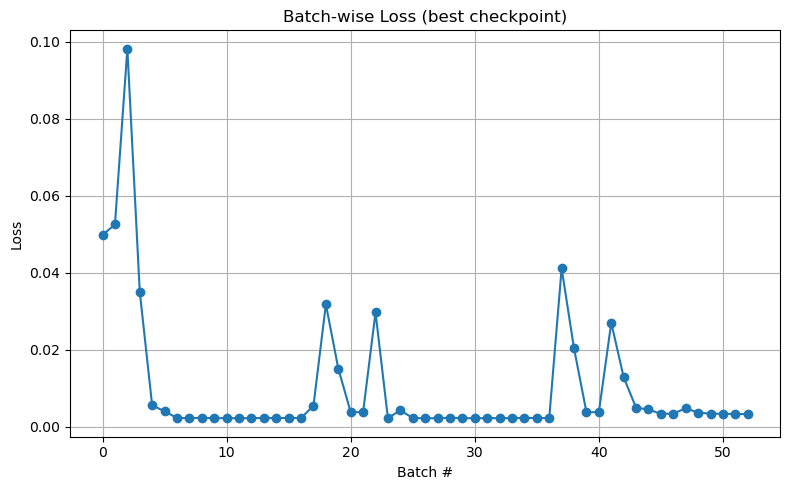

In [12]:
#Batch-wise loss
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([imbalance_ratio(train_loader)], device=device)
)
batch_losses = plot_batch_loss(model, test_loader, criterion, device)
